# fx trading strategies in crypto space

- [introduction](#introduction)
- [assumptions](#assumptions)
- [carry?](#carry?)
- [how/what to trade](#how/what-to-trade)
- [payoff calculation](#payoff-calculation)
    - [long](#long)
    - [short](#short)
    - [long-short](#long-short)
- [results](#results)

## introduction
Cryptocurrencies are quite rapidly becoming a fully-fledged investable asset. One can debate about the lack of fundamental value, questionable incentives of issuers and end users, uncertain regulatory future etc. &mdash; but as long as there is supply and demand, an open market, derivative products and sufficient liquidity, Bitcoin and its peers are just as assety as stocks, bonds and commodity products.

Existence of a derivatives market, specifically futures, calls forth the concept of carry and provides a way to quantify it. In this short piece, I am using perpetual swaps, funding rates and spot prices from the cryptocurrency exchange Kraken to construct a simple long-short carry trade strategy on the set of five most liquid cryprocurrencies and investigate its properties. 

## assumptions
1. USD is the currency of consumption;
1. trading takes place on Kraken;
1. investors can trade at mid prices;
1. investors do not move the market;
1. costs of setting up a crypto wallet and depositing/withdrawing liquidity are zero;
1. spot selling is at zero additional cost in terms of money and time.

Assumptions 1-3 are boring; assumption 4 is violated the more, the **larger** the trading volume [*TODO: references about trade sizes?*], and assumption 5 is violated the more, the **smaller** the trading volume; assumption 6 is violated regardless.

With these assumptions in place, I can answer the question whether the carry trade is there but not whether it is certainly economically profitable to execute. Still fun.

## carry?
"Carry trade" is a strategy for an investor who hopes that the spot price does not move over the investment horizon. It is constructed by taking long forward positions in assets with high, and short &mdash; in those with low "carry". The "carry" is the difference between the currently observed spot and futures prices, and is related to the opportunity costs and the costs of holding ("carrying") the asset.

## how/what to trade
The most liquid contracts to implement strategies with are the so-called [perpetual futures](https://support.kraken.com/hc/en-us/articles/360022835911-Inverse-crypto-collateral-perpetual-contract-specifications): these can be thought of as 4-hour swaps that are automatically rolled over earning what is called the [funding rate](https://blog.kraken.com/post/3075/quick-primer-on-funding-rates/https://blog.kraken.com/post/3075/quick-primer-on-funding-rates/). The latter is not dissimilar to the interest earned by the holder of a long ForEx position: longs pay shorts a certain amount which is determined based on the difference between the recent futures and spot prices. If the futures has been traded too high relative to the spot, the funding rate becomes high also, incentivising market participants to take short positions (to be able to earn this high rate) and thus driving the futures price back down. 

Probably because financial intermediaries shun away from clearing  transactions involving fiat and cryptocurrencies, there are no familiar analogues to USDRUB, AUDUSD etc; it is not common to put USD as collateral to trade futures and realize PnL in dollars. Two alternatives exist: linear futures with stablecoins as the counter currency (such as Binance futures on ETHUSDT) and inverse futures margined in cryptocurrency (such as Kraken futures on ETHUSD). 

The former are the more familiar contracts as far as the specifications and PnL calculation are concerned, but require to purchase the countercurrency coins first, such as the Tether (USDT) or USD coin (USDC) -- two of the so-called stablecoins. A standard trade would go as follows:
1. buy USDT for USD on the spot market;
1. use USDT in the margin account to collateralize a position in ETHUSDT, BTCUSDT etc.;
1. realize PnL in USDT;
1. sell USDT for USD to consume.

An obvious disadvantage is the additional USD-USDT risk.

Inverse crypto-collateral futures are essentialy linear futures on the inverse of the pair. They seem to be more cost-efficient and do not involved a third currency, but contain implicit leverage for an investor with consumption denominated in the fiat currency (details later). A standard trade would go as follows:
1. buy the contract margin cryptocurrency for USD on the spot market;
1. use it to collateralize a position in the futures on the same cryptocurrency;
1. realize PnL in the cryptocurrency;
1. sell the cryptocurrency for USD to consume.

In what follows, I will use the inverse futures.

## return calculation
I use the following conventions:

* $S$ : spot exchange rate, denominated in USD;
* $F$ : futures rate, denominated in USD;
* $q$ : absolute funding rate, in coins per contract;
* $N_i$ : number of contracts of side $i, i \in (l, s)$ for (long, short);
* $r$ : net return, in fractions of 1, such as 0.1 for 10%

At time $t$ we start with 1 USD. Since the contracts are coin-margined, we need to convert this 1 USD into coins at rate $S_t$ and use it as collateral for all positions we will open. On most exchanges one contract is worth 1 USD and hence represents $\frac{1}{F_t}$ coins at inception.

### long

Being long $N_l$ inverse futures at rate $F_t$ is essentially being short USD at rate $\frac{1}{F_t}$, hence the payoff at time $t+1$ is $\left( \frac{1}{F_t} - \frac{1}{F_{t+1}} \right)$ coins. So, at $t+1$ we have a total of $N_l \left( \frac{1}{F_t} - \frac{1}{F_{t+1}}\right)$ coins in trading profit plus $\frac{1}{S_t}$ coins in the collateral account, all of which can be converted back at the prevailing rate for the total USD profit of:
\begin{equation*}
    N_l \left( \frac{1}{F_t} - \frac{1}{F_{t+1}}\right)S_{t+1} + \frac{S_{t+1}}{S_t}.
\end{equation*}
Now, assuming that $S \approx F$ and using $r = \frac{S_{t+1}}{S_t} - 1$, the above amount is equal to:
\begin{equation}
    1 + r(N_l + 1)
    \label{gross_ret_simplified}\tag{1}
\end{equation}
Since we started with 1 USD, this is also the gross return on our investment. Behold the implicit leverage: if we are long (the obvious minimum of) 1 contract, our return is twice the spot return! 

The final thing to take account of is the funding rate: being long, we pay the funding rate of $q_t$ coins per contract (note that this is the "absolute" funding rate, not the relative counterpart displayed at the front end of the exchanges). The exact gross return formula for a long position becomes:
\begin{equation}
    N_l \left( \frac{1}{F_t} - \frac{1}{F_{t+1}} - q_t \right) S_{t+1} + 
    \frac{S_{t+1}}{S_t}.
\end{equation}


### short

Being short $N_s$ inverse futures at rate $F_t$ is essentially being long USD at rate $\frac{1}{F_t}$. Similar considerations lead to the following equivalent of eq. [1](#mjx-eqn-gross_ret_simplified):
\begin{equation}
    1 + r(1 - N_s).
\end{equation}
Curiously, a zero-leverage short position of 1 contract *cannot grow or drop* in value in USD terms! If the coin price falls, we have more coins, which are worth less, and also the collateral account loses USD -- these forces cancel each other out. To be able to lose or earn USD, leverage is needed.

Before we proceed, here is the exact gross return formula for a short position:
\begin{equation}
    N_s \left( \frac{1}{F_{t+1}} - \frac{1}{F_t} + q_t \right) S_{t+1} + 
    \frac{S_{t+1}}{S_t}.
\end{equation}

### long-short


In a long-short portfolio, to make the long leg have the same leverage as the short, we can set $N_l=1$ and $N_s=3$, resulting in a multiplier of 2 on each. Since one contract is worth 1 USD, and we start with 1 USD in the collateral account, we have to open a total of 4 USD worth of contracts having 1 USD to collateralize them. Most exchanges would allow for much higher ratios.

As an example, imagine that the price of the coins in the long and short leg increases by 15\% and 5\% respectively: the portfolio return in this case (disregarding the tiny differences between $F$ and $S$ as well the funding rates) is $2(0.15 - 0.05)=20\%$.

## results

### imports and parameters

In [1]:
import pandas as pd
import seaborn as sns
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter

from foolbox.econometrics.misc import descriptives
from foolbox.backtesting.sorting import rank_sort

from src.setup import *

from src.datafeed_.kraken.downstream import (get_funding_rate, 
                                             get_spot, 
                                             get_perpetual)

In [2]:
# pandas display settings
pd.set_option("display.precision", 2)

# parameters
t_hold = 1  # holding period, in multiples of a 4-hour period
ann = 365 * 6  # there are 6 4-hour periods per day
legsize = 2  # leg size
signal_lookback = 6 * 7  # 7 days lookback to compute carry signal

### data
All data is from Kraken, snapped at 4 hour intervals starting at 00:00.

### funding rates

In [3]:
# abs and relative funding rate
data_f = get_funding_rate()
print(data_f.tail())

asset                 timestamp      rate       xbt       bch       ltc  \
14261 2021-12-02 00:00:00+00:00  relative  2.17e-06  4.17e-05 -1.05e-05   
14262 2021-12-02 04:00:00+00:00  absolute -5.23e-10  4.44e-08 -5.23e-08   
14263 2021-12-02 04:00:00+00:00  relative -2.95e-05  2.50e-05 -1.06e-05   
14264 2021-12-02 08:00:00+00:00  absolute -2.93e-10  3.84e-08 -4.76e-09   
14265 2021-12-02 08:00:00+00:00  relative -1.67e-05  2.17e-05 -9.71e-07   

asset       eth       xrp  
14261 -9.51e-06  1.36e-05  
14262 -1.01e-09  7.16e-06  
14263 -4.55e-06  6.93e-06  
14264 -2.33e-10 -1.21e-06  
14265 -1.06e-06 -1.18e-06  


In [4]:
# carry is the negative of the relative funding rate, ~(spot / fwd - 1)
carry = data_f \
    .query("rate == 'relative'").drop("rate", axis=1) \
    .set_index("timestamp") \
    .mul(-1)

Text(0, 0.5, 'percent p.a.')

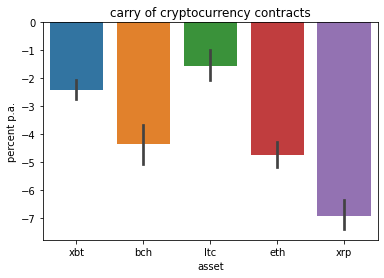

In [5]:
# plot
ax = sns.barplot(data=carry * ann * 100)
ax.set_title("carry of cryptocurrency contracts")
ax.set_ylabel("percent p.a.")

In [6]:
# print descriptives (some are meaningless)
carry_d = descriptives(carry, ann=ann, scl=100, cov_lags=30)

print("carry of cryptocurrency contracts: descriptives\n")
print(carry_d.iloc[:-2])
print("-" * 41 + "\n")
print("values are in percent p.a. where relevant.\n")

carry of cryptocurrency contracts: descriptives

asset     xbt    bch    ltc    eth    xrp
mean    -2.41  -4.36  -1.55  -4.73  -6.93
sterr    0.73   1.32   1.20   0.89   0.97
tstat   -3.30  -3.30  -1.29  -5.31  -7.16
median  -1.54  -5.75  -2.06  -4.54  -5.33
std      0.31   0.63   0.51   0.41   0.50
dstd     0.24   0.39   0.32   0.29   0.39
q95     18.70  41.86  39.02  25.20  24.71
q05    -26.95 -42.01 -35.72 -33.62 -45.65
skew    -0.02   1.14   0.94   0.53  -0.05
kurt     6.91   7.12   6.36   7.38   6.11
sharpe  -7.75  -6.97  -3.05 -11.51 -13.93
ac1      0.77   0.74   0.81   0.75   0.72
-----------------------------------------

values are in percent p.a. where relevant.



### spot price

In [8]:
# spot price
data_s = get_spot()\
    .resample("4H", closed="right", label="right").last()\
    .loc["2018-08":]
print(data_s)

asset                         bch      eth     ltc       xbt   xrp
timestamp                                                         
2018-08-01 00:00:00+00:00  776.34   432.39   78.93   7736.18  0.43
2018-08-01 04:00:00+00:00  740.33   416.79   76.71   7528.43  0.43
2018-08-01 08:00:00+00:00  759.99   422.23   77.46   7577.52  0.44
2018-08-01 12:00:00+00:00  764.33   424.49   77.86   7580.71  0.45
2018-08-01 16:00:00+00:00  758.50   420.51   77.63   7599.77  0.45
...                           ...      ...     ...       ...   ...
2021-09-30 08:00:00+00:00  498.94  3004.50  150.96  43380.30  0.94
2021-09-30 12:00:00+00:00  494.45  2965.49  151.11  43068.09  0.94
2021-09-30 16:00:00+00:00  496.72  2982.86  152.44  43139.59  0.94
2021-09-30 20:00:00+00:00  498.39  2997.42  151.83  43642.44  0.95
2021-10-01 00:00:00+00:00  502.50  3000.58  153.17  43775.23  0.95

[6943 rows x 5 columns]


Text(0.5, 0, '')

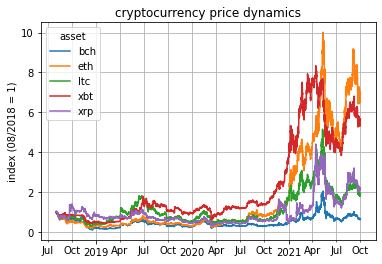

In [9]:
# plot spot price index
spot_idx = data_s.div(data_s.iloc[0], axis=1)
ax = sns.lineplot(data=spot_idx, dashes=False)

# formatting
ax.set_xticks(
    pd.period_range("2018-09", "2021-03", freq="6M").to_timestamp()
)
ax.xaxis.set_major_locator(YearLocator(1))
ax.xaxis.set_minor_locator(MonthLocator([4, 7, 10]))
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
ax.xaxis.set_minor_formatter(DateFormatter("%b"))

ax.grid(which="both")

ax.set_title("cryptocurrency price dynamics")

ax.set_ylabel("index (08/2018 = 1)")
ax.set_xlabel("", visible=False)

### perpetual futures price

In [10]:
# perpetual futures prices
data_p = get_perpetual(mid=True) \
    .resample("4H", closed="right", label="right").last()

print(data_p.reindex_like(data_s))

asset                         bch      eth     ltc       xbt   xrp
timestamp                                                         
2018-08-01 00:00:00+00:00     NaN      NaN     NaN       NaN   NaN
2018-08-01 04:00:00+00:00     NaN      NaN     NaN       NaN   NaN
2018-08-01 08:00:00+00:00     NaN      NaN     NaN       NaN   NaN
2018-08-01 12:00:00+00:00     NaN      NaN     NaN       NaN   NaN
2018-08-01 16:00:00+00:00     NaN      NaN     NaN       NaN   NaN
...                           ...      ...     ...       ...   ...
2021-09-30 08:00:00+00:00  500.35  3005.80  150.99  43358.53  0.94
2021-09-30 12:00:00+00:00  495.07  2965.74  151.01  43084.61  0.94
2021-09-30 16:00:00+00:00  497.87  2986.30  152.64  43111.08  0.95
2021-09-30 20:00:00+00:00  502.11  3000.78  151.88  43625.02  0.95
2021-10-01 00:00:00+00:00  502.01  3012.49  153.05  43896.90  0.95

[6943 rows x 5 columns]


In [11]:
# the signal is the rolling median
carry_sig = carry\
    .rolling(signal_lookback, min_periods=signal_lookback // 2)\
    .median()\
    .shift(1)

# portfolio sorts
sorts = rank_sort(carry_sig, legsize=legsize)

print(sorts[["p_low", "p_high"]].tail(6))

/home/ipozdeev/projects/python-packages/foolbox/backtesting/sorting.py:198: RuntimeWarning: invalid value encountered in true_divide
  bins = (np.array(nass)/n_assets+epsilon).cumsum()


portfolio                 p_low                     p_high                    
asset                       xbt  bch  ltc  eth  xrp    xbt  bch  ltc  eth  xrp
timestamp                                                                     
2021-12-01 12:00:00+00:00   0.0  1.0  0.0  0.0  1.0    1.0  0.0  1.0  0.0  0.0
2021-12-01 16:00:00+00:00   0.0  1.0  0.0  0.0  1.0    1.0  0.0  1.0  0.0  0.0
2021-12-01 20:00:00+00:00   0.0  1.0  0.0  0.0  1.0    1.0  0.0  1.0  0.0  0.0
2021-12-02 00:00:00+00:00   0.0  1.0  0.0  0.0  1.0    1.0  0.0  1.0  0.0  0.0
2021-12-02 04:00:00+00:00   0.0  1.0  0.0  0.0  1.0    1.0  0.0  1.0  0.0  0.0
2021-12-02 08:00:00+00:00   0.0  1.0  0.0  0.0  1.0    1.0  0.0  1.0  0.0  0.0


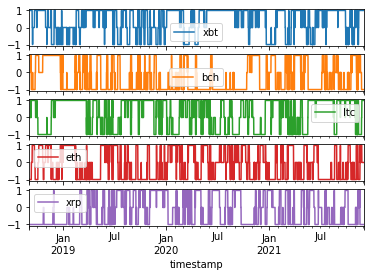

In [12]:
# plot positions
ax = sorts["p_high"].add(sorts["p_low"].mul(-1)).plot(subplots=True)

In [13]:
# forward-looking returns and funding (levered x2)
# need 1 long and 3 short contracts to achieve the same level of leverage
n_long = 1
n_short = 3

# absolute funding rate
data_f = get_funding_rate() \
    .query("rate == 'absolute'").drop("rate", 1) \
    .set_index("timestamp")

# long
r_long = n_long * data_s.shift(-t_hold) * \
     (1 / data_p - 1 / data_p.shift(-t_hold) -
      data_f.shift(1).mul(4).rolling(t_hold).sum().shift(-t_hold + 1)) + \
     data_s.shift(-t_hold) / data_s - 1

r_short = n_short * data_s.shift(-t_hold) * \
      (1 / data_p.shift(-t_hold) - 1 / data_p +
       data_f.shift(1).mul(4).rolling(t_hold).sum().shift(-t_hold + 1)) + \
      data_s.shift(-t_hold) / data_s - 1

rx = pd.concat([r_long, r_short], axis=1, keys=["p_high", "p_low"],
               names=["portfolio", "asset"])

/tmp/ipykernel_199592/2706435654.py:7: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  data_f = get_funding_rate() \


In [14]:
# take a look at returns
print("p_high (x2 leverage):")
print(descriptives(rx.xs("p_high", axis=1), ann=ann/t_hold, scl=100))
print("\np_low (x2 leverage):")
print(descriptives(rx.xs("p_low", axis=1), ann=ann/t_hold, scl=100))

p_high (x2 leverage):
asset        bch       eth       ltc       xbt       xrp
mean      225.22    222.40    166.40    165.74    171.36
sterr     135.38    109.38    123.14     84.85    133.84
tstat       1.66      2.03      1.35      1.95      1.28
median     75.32     94.07     33.33    121.63     20.22
std       228.82    196.24    210.76    152.46    235.01
dstd      176.58    152.56    161.05    124.08    179.48
q95     15932.62  14434.09  14915.17  11044.00  15370.22
q05    -15152.02 -13721.73 -14404.59 -10106.47 -14640.36
skew       -0.04     -0.37     -0.26     -0.45      0.47
kurt       12.32      8.59      6.44     14.17     18.74
sharpe      0.98      1.13      0.79      1.09      0.73
ac1        -0.04     -0.05     -0.03     -0.05     -0.03
count    6010.00   6695.00   6227.00   6740.00   6573.00
maxdd     234.44    238.63    256.50    187.92    260.40

p_low (x2 leverage):
asset        bch       eth       ltc       xbt       xrp
mean     -163.36   -184.56   -129.51   -147.

In [15]:
# sort returns into portfolios according to the signal
res_hl = rx.mul(sorts / legsize) \
    .groupby(axis=1, level="portfolio").sum(min_count=1) \
    .loc[:, ["p_high", "p_low"]].dropna()

# high minus low
res_hl.insert(0, "p_hml", res_hl.eval("p_high + p_low"))

print(res_hl.tail(6))

portfolio                     p_hml    p_high     p_low
timestamp                                              
2021-09-30 00:00:00+00:00  1.10e-04  7.95e-02 -7.93e-02
2021-09-30 04:00:00+00:00 -1.33e-02 -1.77e-02  4.36e-03
2021-09-30 08:00:00+00:00  1.28e-02 -4.63e-03  1.74e-02
2021-09-30 12:00:00+00:00  1.14e-02  1.75e-02 -6.08e-03
2021-09-30 16:00:00+00:00 -2.60e-02 -2.84e-03 -2.32e-02
2021-09-30 20:00:00+00:00  1.28e-02  1.60e-02 -3.20e-03


In [16]:
rx_d = descriptives(res_hl, ann=(ann / t_hold), scl=100)

print(rx_d)

portfolio    p_hml    p_high     p_low
mean        218.87    265.14    -46.27
sterr        65.73     98.79    109.69
tstat         3.33      2.68     -0.42
median      226.78     71.60      0.00
std         119.22    178.62    195.68
dstd         93.25    146.36    138.03
q95        7925.25  12541.22  13489.44
q05       -7511.77 -11628.63 -13881.04
skew          0.42     -0.53      0.78
kurt         15.97     12.80      9.54
sharpe        1.84      1.48     -0.24
ac1          -0.06     -0.06     -0.03
count      6737.00   6737.00   6737.00
maxdd       147.25    165.64    532.35


Text(0, 0.5, 'payoff w/o reinvestment, in USD')

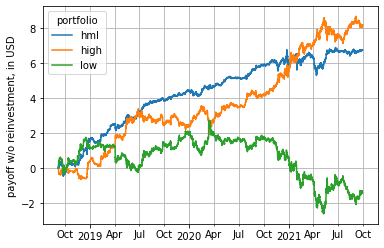

In [17]:
# plot
to_plot = res_hl.cumsum()\
    .rename(columns=lambda x: x[2:])\
    .reset_index().melt(id_vars=["timestamp"], value_name="payoff")
ax = sns.lineplot(x="timestamp", y="payoff", data=to_plot, hue="portfolio")

ax.xaxis.set_major_locator(YearLocator(1))
ax.xaxis.set_minor_locator(MonthLocator([1, 4, 7, 10]))
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
ax.xaxis.set_minor_formatter(DateFormatter("%b"))
ax.grid(True, which="both")

ax.set_xlabel("", visible=False)
ax.set_ylabel("payoff w/o reinvestment, in USD")